# Каскадные системы. Синтез управления методом бэкстеппинга

Рассмотрим задачу о стабилизации верхнего положения маятника.

Уравнения движения:

$$
m l^2 \ddot{\alpha} - m g l \sin{\alpha} = M_{\mathrm{упр}} \rightarrow
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + u
    \end{array}   
\right.
$$

Расмотрим управляющее воздействие вида
$$
u(\alpha,\omega) = k_1 \alpha + k_2 \sin{\alpha} + k_3 \omega.
$$

Для анализа устойчивости вертикального равновесия с выбранным законом управления рассмотрим функцию Ляпунова вида:
$$
    V(\alpha, \omega) = \frac{1}{2}(\alpha + \omega)^2 + \frac{1}{2}\omega^2.
$$

Вычислим производную V в силу вранений движения:
$$
\dot{V}(\alpha, \omega) = (\alpha+\omega)\omega + (\alpha + 2\omega)(\frac{g}{l}\sin{\alpha}+k_1 \alpha + k_2 \sin{\alpha} + k_3 \omega).
$$

Выберем коэффициенты $k_1, k_2, k_3$ так, чтобы обеспечить выполнение условия $\dot{V}<0$. Положим $k_2 = -g/l$:
$$
\dot{V}(\alpha, \omega) = k_1 \alpha^2 + (1 + 2 k_3) \omega^2 + (1 + 2k_1 + k_3)\alpha\omega.
$$

Положив $k_1 = -1/8$, $k_3 = -3/4$, получим
$$
\dot{V}(\alpha, \omega) = -\frac{1}{8}\alpha^2 - \frac{1}{2}\omega^2 < 0.
$$

Таким образом, закон управления:
$$
u(\alpha, \omega) = -\frac{1}{8}\alpha - \frac{g}{l}\sin{\alpha} -\frac{3}{4}\omega.
$$

In [4]:
import numpy as np
import sympy as sp
import scipy.integrate as sci
import matplotlib.pyplot as plt

In [5]:
class Parameters(object):
    pass

param = Parameters()
param.g = 10
param.l = 1
param.gl = param.g / param.l

def control(x):
    return -x[0]/8 - param.gl * np.sin(x[0]) - 3/4 *  x[1]

def rhs(t, x):
    dxdt = np.zeros(2)
    
    dxdt[0] = x[1]
    dxdt[1] = param.gl * np.sin(x[0]) + control(x)
    
    return dxdt

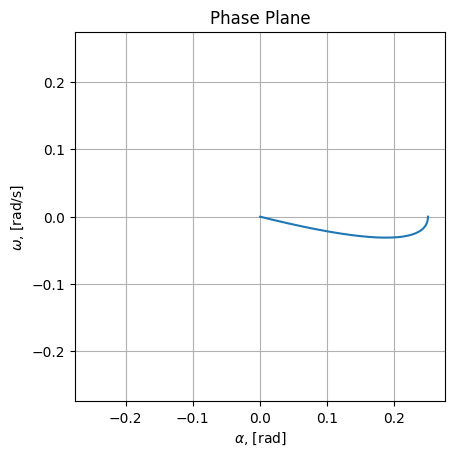

In [6]:
t0, tf, dt = 0, 100, 0.1
t_sol = np.arange(t0, tf, dt)

x0 = [0.25, 0]

sol = sci.solve_ivp(rhs, (t0, tf), x0, t_eval = t_sol)

x_sol = sol.y.T

pltlim = 1.1*max(max(x_sol[:,0]), max(x_sol[:,1]))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(-pltlim, pltlim)
plt.ylim(-pltlim, pltlim)
ax.plot(x_sol[:, 0], x_sol[:, 1])
ax.grid(True)
ax.set_title('Phase Plane')
ax.set_ylabel(r'$\omega$, [rad/s]')
ax.set_xlabel(r'$\alpha$, [rad]')
ax.set_aspect('equal')

Пусть теперь задача управления поставлена для динамической системы, описываемой системой дифференциальных уравнений
$$
\dot{x} = f(x,u,t),
$$

и пусть некоторой заменой переменных эта система приводится к виду:

$$
\begin{equation}\tag{1}
\left\{
    \begin{array}\\
       \dot{\eta} = f_0(\eta) + g_0(\eta)\xi_1, \\
       \dot{\xi}_1 = f_1(\eta, \xi_1) + g_1(\eta, \xi_1)\xi_2,\\
       \dot{\xi}_2 = f_2(\eta, \xi_1, \xi_2) + g_2(\eta, \xi_1, \xi_2)\xi_3,\\
       \vdots \\
       \dot{\xi}_{n-m} = f_{n-m}(\eta, \xi_1,..., \xi_{n-m}) + g_{n-m}(\eta, \xi_1,..., \xi_{n-m})u
    \end{array}   
\right. 
\end{equation}
$$

Таким образом, в новых переменных система принимает блочный нижне-треугольный вид, начинающийся с неприводимого блока, отвечающего переменным $\eta$.

Частным случаем такой системы, является система, включающая несколько последовательно включенных интеграторов
$$
\begin{equation}\tag{2}
\left\{
    \begin{array}\\
       \dot{\eta} = f_0(\eta) + g_0(\eta)\xi_1, \\
       \dot{\xi}_1 = \xi_2,\\
       \dot{\xi}_2 = \xi_3,\\
       \vdots \\
       \dot{\xi}_{n-m} = u
    \end{array}   
\right. 
\end{equation}
$$

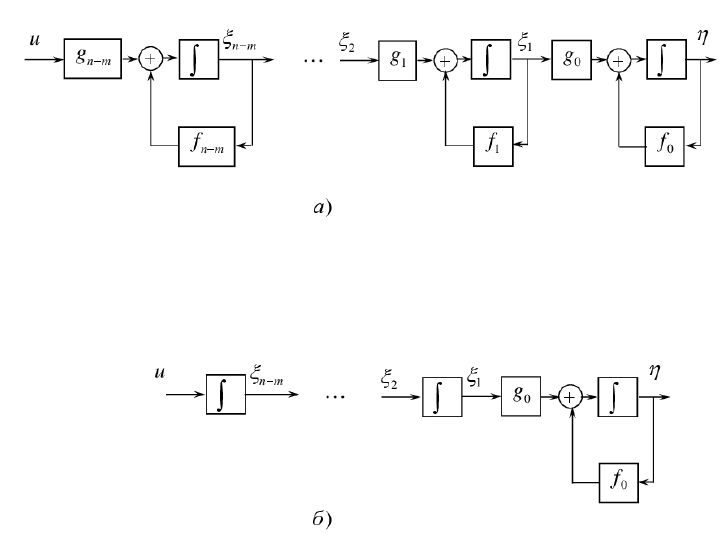

Благодаря рекурсивной структуре системы синтез управления можно начать со стабилизации первой неприводимой системы  в переменных $\eta$. Затем полученный закон управления последовательно наращивается включением в рассмотрение новых переменных $\xi_i$, при этом мы пошагово двигаемся по блоксхеме полной системы справа налево (то есть в обратном направлении), что и дало название методу - backstepping.

Схематично метод бэкстеппинга работает следующим образом:

1. Рассмотрим первую подсистему системы (1) в переменных $\eta$, взяв $\xi_1$ в качестве управления. Пусть эта система может быть стабилизирована с помощью закона управления $\xi_1 = \varphi_0(\eta)$, удовлетворяющего условию $\varphi_0(0)=0$, таким образом, что нулевое решение системы
$$
\begin{equation}\tag{3}
\dot{\eta} = f_0(\eta) + g_0(\eta)\varphi_0(\eta) 
\end{equation}
$$
асимптотически устойчиво. Кроме того, будем считать, что нам известна положительно определённая функция Ляпунова
$$
V_0(\eta): \quad  \quad \dot{V}_0 = \frac{\partial V_0}{\partial \eta}\dot{\eta} = W_0(\eta) <0
$$
в некоторой окрестности нуля.


2. Рассмотрим вторую подсистему системы (1) относительно переменной $\xi_1$, взяв в качестве управления $\xi_2$, и синтезируем закон управления $\xi_2 = \varphi_1(\eta, \xi_1)$, удовлетворяющий условию $\varphi_1(0,0) = 0$, таким образом, что система, состоящая из (1) и
$$
\dot{\xi}_1 = f_1(\eta, \xi_1) + g_1(\eta, \xi_1)\xi_2
$$
имеет асимптотически устойчивое нулевое решение, причём переменная $\xi_1$ повторяет закон управления $\varphi_0(\eta)$, синтезированный на предыдущем шаге. Для синтеза закона управления $\xi_2 = \varphi_1(\eta, \xi_1)$ используем функцию Ляпунова
$$
V_1(\eta, \xi_1) = V_1(\eta) + \frac{1}{2}\left(\xi_1 - \varphi_0(\eta)\right)^2
$$

Закон управления $\varphi_1(\eta, xi_1)$ выбираем такким образом, чтобы добиться отрицательной определённости производной
$$
\dot{V}_1 = \frac{\partial V_1}{\partial \eta} \dot{\eta} + \frac{\partial V_1}{\partial \xi_1} \dot{\xi_1} = W_1(\eta, \xi_1) <0
$$

3. Процесс пошагового синтеза управления продолжается до шага с номером $n-m$, на котором синтезируется закон управления $u$.


Можно показать, что для системы вида (2)  с одним интегратором, закон управления имеет вид:
$$
u(\eta, \xi) = \frac{\partial \varphi_0(\eta)}{\partial \eta} \left( f_0(\eta) + g_0(\eta) \xi\right) - \frac{\partial V_0(\eta)}{\partial \eta} g_0(\eta) - \lambda (\xi - \varphi(\eta)), \quad \lambda > 0
$$


Подробное обоснование метода см. например, в книге 
 Поляк Б.Т., Хлебников М.В., Рапопорт Л.Б. Математическая теория автоматического управления: учебное пособие. - М.: Ленанд, 2019.

## Пример

Вернёмся к примеру о стабилизации верхнего положения математического маятника. Пусть нужно стабилизировать верхнее положение математического маятника при помощи рулевой машинки. Будем считать, что уравнения описывающие мащинку можно представить в виде двойного интегратора.

обозначив через $\alpha$ отклонение от вертикали и через $\omega$ угловую скорость, запишем:
$$
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + \xi_1, \\
       \dot{\xi}_1 = \xi_2, \\
       \dot{\xi}_2 = u
    \end{array}   
\right.
$$

Синтез закона управления, стабилизирующего нулевое положение этой системы, разобъём на два шага в соответствии с описанной схемой. На первом шаге рассмотрим стабилизацию системы с одним интегратором:

$$
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + \xi_1, \\
       \dot{\xi}_1 = \xi_2
    \end{array}   
\right.
$$

и управлением $\xi_2$, для синтеза которого применим один шаг бэкстеппинга.

Из предыдущего примера для $\eta = (\alpha, \omega)$
$$
\varphi_0(\eta) = -\frac{1}{8}\alpha -\frac{g}{l}\sin{\alpha}-\frac{3}{4}\omega, \quad V_0(\eta) = \frac{1}{2}(\alpha + \omega)^2 + \frac{1}{2}\omega^2.
$$

При этом
$$
W_0(\eta) = -\frac{1}{8}\alpha^2 - \frac{1}{2}\omega^2. 
$$

In [7]:
def control_bck1(x):
    lmbda0  = 10
    
    a = (1 + lmbda0 / 8)
    b = (17/8 + 3 * lmbda0 / 4)
    c = (3/4 + lmbda0)
    
    ctrl = - a * x[0] -b * x[1] - c * param.gl * np.sin(x[0]) - param.gl * x[1] * np.cos(x[0]) - c * x[2]
    
    return ctrl

def rhs_bck1(t, x):
    dxdt = np.zeros(3)
    
    dxdt[0] = x[1]
    dxdt[1] = param.gl * np.sin(x[0]) + x[2]
    dxdt[2] = control_bck1(x)
        
    return dxdt

def control_bck2(x):
    lmbda0  = 10
    lmbda1 = 10
    
    a = (1 + lmbda0 / 8)
    b = (17 / 8 + 3 * lmbda0 / 4)
    c = (3 / 4 + lmbda0)
    e = x[2] + x[0] / 8 + param.gl * np.sin(x[0]) + 3 * x[1] / 4
    
    ctrl  = x[0] * x[1] + x[1]**2 + e * x[1] * (1/8 + param.gl * np.cos(x[0])) + \
            (x[0] + 2 * x[1] + 3 * e / 4) * (param.gl * np.sin(x[0]) + x[2]) + e * x[3] - e - \
            lmbda1 * (x[3] + a * x[0] + b * x[1] + c * param.gl * np.sin(x[0]) + param.gl * x[1] * np.cos(x[0]) + c * x[3])
    return ctrl

def rhs_bck2(t, x):
    dxdt = np.zeros(4)
    
    dxdt[0] = x[1]
    dxdt[1] = param.gl * np.sin(x[0]) + x[2]
    dxdt[2] = x[3]
    dxdt[3] = control_bck2(x)
    
    
    return dxdt

In [8]:
from sympy.abc import *
import sympy.printing as printing


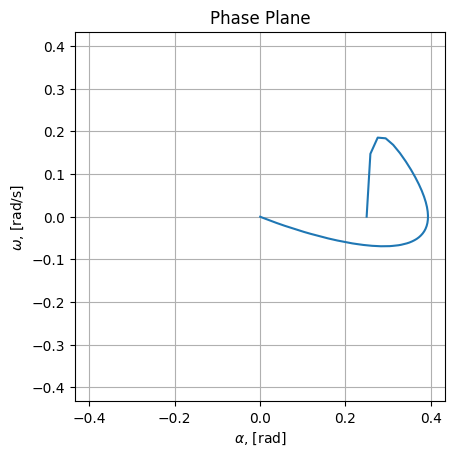

In [9]:
t0, tf, dt = 0, 20, 0.1
t_sol = np.arange(t0, tf, dt)

x0 = [0.25, 0, 0]

sol = sci.solve_ivp(rhs_bck1, (t0, tf), x0, t_eval = t_sol)

x_sol = sol.y.T

pltlim = 1.1*max(max(x_sol[:,0]), max(x_sol[:,1]))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(-pltlim, pltlim)
plt.ylim(-pltlim, pltlim)
ax.plot(x_sol[:, 0], x_sol[:, 1])
ax.grid(True)
ax.set_title('Phase Plane')
ax.set_ylabel(r'$\omega$, [rad/s]')
ax.set_xlabel(r'$\alpha$, [rad]')
ax.set_aspect('equal')

Попробуем оформить задачу в инструментах sympy.
Введем обозначения:

In [10]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
from sympy import *


class Parameters(object):
    pass



def control(x):
    return -x[0]/8 - param.gl * np.sin(x[0]) - 3/4 *  x[1]

def rhs(t, x):
    dxdt = np.zeros(2)
    
    dxdt[0] = x[1]
    dxdt[1] = param.gl * np.sin(x[0]) + control(x)
    
    return dxdt

In [52]:
def sym_control_bck1(x):
    la = Symbol('\lambda_0')
    lmbda0  = 10
    a = Symbol('1')+sympify(x /8)
    b = sympify("17/8", evaluate = False) + 3 * sympify(la /4)
    c = sympify("3/4", evaluate = False) + la
    ctrl = - a * x[0] -b * x[1] - c * param.gl * np.sin(x[0]) - param.gl * x[1] * np.cos(x[0]) - c * x[2]

In [54]:
from sympy.matrices import Matrix 
t0, tf, dt = symbols('t_0, t_f, dt')
T = Matrix([[t0], [tf], [dt]]) 
T_num = Matrix([[0], [20], [0.1]]) 

x0_num =  Matrix([[0.25], [0], [0]])
## T = T_num

la = Symbol('\lambda_0')
lmbda0  = 10
a = Symbol('1')+sympify(1/8)
b = sympify("17/8", evaluate = False) + 3 * sympify(la /4)
c = sympify("3/4", evaluate = False) + la


In [40]:
from sympy import Symbol, sympify, symbols, Function, Array, cos, sin, simplify, lambdify
from sympy.calculus.euler import euler_equations
from sympy.printing.latex import LatexPrinter, print_latex

from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

In [50]:
g, l, omega, alpha, u, xi1, xi2, nu, psi0, psi1, psi2, V0, V1, V2, W0, W1, W2 = symbols('g, l, \\omega, \\alpha, u, \\xi_1, \\xi_2, \\eta, \\varphi_0, \\varphi_1, \\varphi_2, V_0, V_1, V_2, W_0, W_1, W_2')

psi0 = Function('\\varphi_0')(nu)
V0  = Function('V_0')(nu)
W0  = Function('W_0')(nu)
nu = (alpha,omega)

psi0 = -0.125*alpha + sympify(g/l) * sin(alpha) -  0.75 * omega
V0 = 0.5*(alpha+omega)**2 + 0.5*omega**2
W0 = -0.125*(alpha)**2 - 0.5*omega**2




Нужно найти такие $ \xi_1$, $ \xi_2$, $u$ для системы:
$$
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + \xi_1, \\
       \dot{\xi}_1 = \xi_2, \\
       \dot{\xi}_2 = u
    \end{array}   
\right.
$$
Такие, что:


$$\begin{array}\\
    \xi_1 = \varphi_0 (\eta) \\
    \downarrow \\               	
    \xi_2 = \varphi_1 (\eta, \xi_1) \\
    \downarrow \\
     u = \varphi_2 (\eta, \xi_1, \xi_2) \\    
    \end{array}$$

Зная $\xi_1$ (из первого примера), ищем $\xi_2$ для синтеза которого применим один шаг бэкстеппинга.
$$
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + \xi_1, \\
       \dot{\xi}_1 = -\frac{1}{8}\dot{\alpha}  - \frac{g}{l}\cos{\alpha}\dot{\alpha} - \frac{3}{4}\dot{\omega}, \\
       \dot{\xi}_2 = u
    \end{array}   
\right.
$$
## --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
### Уточнение шага
1.
$$
\eta = 
\left( \begin{array}\\
       \alpha \\
       \omega     
    \end{array} \right)
$$

$$
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + u, \\
    \end{array}   
\right.
$$

$$
f_0 = 
\left( \begin{array}\\
       \omega  \\
       \frac{g}{l}\sin{\alpha}
    \end{array} \right)
$$

$$
g_0 = 
\left( \begin{array}\\
      0 \\
      1
    \end{array} \right)
$$

$$
\dot{\eta} = f_0(\eta) + g_0(\eta)\cdot\xi_1 
$$


$$
u(\eta, \xi_1 ) = \frac{\partial \varphi_0(\eta)}{\partial \eta} \left( f_0(\eta) + g_0(\eta) \xi_1\right) - \frac{\partial V_0(\eta)}{\partial \eta} g_0(\eta) - \lambda (\xi_1 - \varphi_0(\eta)), \quad \lambda > 0
$$

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
2.
$$
\eta = 
\left( \begin{array}\\
       \alpha \\
       \omega  \\
       \xi_1
    \end{array} \right)
$$

$$
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + \xi_1, \\
       \dot{\xi}_1 = u
    \end{array}   
\right.
$$



$$
f_1 = 
\left( \begin{array}\\
       \omega  \\
       \frac{g}{l}\sin{\alpha} + \xi_1 \\
       0
    \end{array} \right)
$$

$$
g_1 = 
\left( \begin{array}\\
      0 \\
      0 \\
      1
    \end{array} \right)
$$

$$
\dot{\eta} = f_1(\eta) + g_1(\eta)\cdot\xi_2 
$$


$$
u(\eta, \xi_1, \xi_2) = \frac{\partial \varphi_1(\eta)}{\partial \eta} \left( f_1(\eta) + g_1(\eta) \xi_2\right) - \frac{\partial V_1(\eta)}{\partial \eta} g_1(\eta) - \lambda (\xi_2 - \varphi_1(\eta)), \quad \lambda > 0
$$

## --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- 


$$\downarrow \\ $$

$$
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + \xi_1, \\
       \dot{\xi}_1 = -\omega(\frac{1}{8} + \frac{g}{l}\cos{\alpha}) - \frac{3}{4}(\frac{g}{l}\sin{\alpha} - \frac{1}{8}\alpha - \frac{g}{l}\sin{\alpha} -  \frac{3}{4}\omega), \\
       \dot{\xi}_2 = u
    \end{array}   
\right.
$$

$$\downarrow \\ $$

$$
\left\{
    \begin{array}\\
       \dot{\alpha} = \omega, \\
       \dot{\omega} =  \frac{g}{l}\sin{\alpha} + \xi_1, \\
       \dot{\xi}_1 = \omega(\frac{7}{16} - \frac{g}{l}\cos{\alpha}) + \frac{3}{32}\alpha, \\
       \dot{\xi}_2 = u
    \end{array}   
\right.
$$

$$
\left\{
    \begin{array}\\
       \dot{\xi}_2 = u, \\
       \xi_2 = \omega(\frac{7}{16} - \frac{g}{l}\cos{\alpha}) + \frac{3}{32}\alpha
    \end{array}   
\right.
$$


Синтезируем закон управления $\xi_2 = \varphi_1(\eta, \xi_1) =  \varphi_1(\alpha, \omega, \xi_1)$, удовлетворяющий условию $\varphi_1(0,0,0) = 0$, тогда преобразуем систему:
$$
\dot{\xi}_1 = f_1(\alpha, \omega, \xi_1) + g_1(\alpha, \omega, \xi_1)\xi_2
$$
имеет асимптотически устойчивое нулевое решение, причём переменная $\xi_1$ повторяет закон управления $\varphi_0(\alpha, \omega)$, синтезированный на предыдущем шаге. Для синтеза закона управления $\xi_2 = \varphi_1(\alpha, \omega, \xi_1)$ используем функцию Ляпунова
$$
V_1(\alpha, \omega, \xi_1) = V_0(\alpha, \omega) + \frac{1}{2}\left(\xi_1 - \varphi_0(\alpha, \omega)\right)^2
$$

$$
V_1(\alpha, \omega, \xi_1) = \frac{1}{2}(\alpha + \omega)^2 + \frac{1}{2}\omega^2 + \frac{1}{2}\left(\xi_1 - \frac{1}{8}\alpha - \frac{g}{l}\sin{\alpha} - \frac{3}{4}\omega \right)^2
$$



Закон управления $\varphi_1(\alpha, \omega, \xi_1)$ выбираем такким образом, чтобы добиться отрицательной определённости производной
$$
\dot{V}_1 = \frac{\partial V_1}{\partial \alpha} \dot{\alpha} + \frac{\partial V_1}{\partial \omega} \dot{\omega} + \frac{\partial V_1}{\partial \xi_1} \dot{\xi_1} = W_1(\alpha, \omega, \xi_1) < 0
$$




Далее
$$
\xi_2(\alpha, \omega, \xi_1) = \frac{\partial \varphi_1(\alpha, \omega)}{\partial \eta} \left( f_1(\alpha, \omega) + g_1(\alpha, \omega) \xi_1\right) - \frac{\partial V_1(\alpha, \omega)}{\partial \eta} g_1(\alpha, \omega) - \lambda (\xi_1 - \varphi_1(\alpha, \omega)), \quad \lambda > 0
$$



In [76]:
from sympy import MatrixSymbol, Matrix, diff
from sympy.physics.vector import *

x = Matrix([alpha, omega, xi1])
f_1 =  Matrix([omega,  sympify(g/l) * sin(alpha) + xi1, 0])
g_1 = Matrix([0,0,1])
f_1 + g_1*xi2

lyambda = symbols('\lambda')


In [82]:
psi1 = Function('\\varphi_1')(nu)

V1  = Function('V_0')(nu)
W1  = Function('W_0')(nu)
nu = (alpha,omega,xi1)

psi1 = -0.125*alpha + sympify(g/l) * sin(alpha) -  0.75 * omega
V1 = V0 + sympify((xi1 - psi0)**2/2)

W1 = W0 - lyambda*sympify((xi1 - psi0)**2/2)

u = Function('u')(alpha,omega,xi1, xi2) 
Ee =  Matrix([0,0, lyambda*(xi2 - psi1)])
u = (diff(psi1, alpha) + diff(psi1, omega))*(f_1 + g_1*xi2)  - (diff(V1, alpha) + diff(V1, omega))*g_1 - Ee
#- (diff(V1, alpha) + diff(V1, omega))*g_1 - lyambda*(xi2 - psi1)
u

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                          ⎛                                    g⋅sin(\alpha)⎞
⎢-2.09375⋅\alpha - \lambda⋅⎜0.125⋅\alpha + 0.75⋅\omega + \xi₂ - ─────────────⎟
⎣                          ⎝                        